核心目标
通过LangGraph框架实现RAG Agent，结合检索（Retrieval）、增强（Augmentation）、生成（Generation）逻辑，使LLM能利用外部知识库生成准确可信的回答。
1. RAG Agent核心逻辑
1. 检索：从知识库中提取相关文档；  
2. 增强：将检索结果融入提示词（Prompt）；  
3. 生成：基于增强后的提示词输出答案。
2. 预处理文档
工具：使用WebBaseLoader加载网页文档。

### 1. 模型配置

1.1 环境变量配置

OPENAI_API_KEY=ollama
OPENAI_MODEL=qwen3
OPENAI_BASE_URL=http://192.168.3.2:11434/v1
OPENAI_TIMEOUT=120
OPENAI_EMBEDDING_MODEL=bge-m3

In [ ]:
from pydantic_settings import BaseSettings, SettingsConfigDict
from pydantic import SecretStr


class Settings(BaseSettings):
    model_config = SettingsConfigDict(
        env_file=".env", env_file_encoding="utf-8", extra="ignore", case_sensitive=False
    )
    openai_api_key: SecretStr
    openai_base_url: str
    openai_model: str  # 评估用LLM
    openai_embedding_model: str  # 嵌入模型
    temperature: float = 0.1  # 固定随机种子，确保评估结果稳定


config = Settings()

In [3]:
config

Settings(openai_api_key=SecretStr('**********'), openai_base_url='http://127.0.0.1:11434/v1', openai_model='qwen3', openai_embedding_model='bge-m3', temperature=0)

1.2 模型配置

In [4]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI, OpenAIEmbeddings


llm = ChatOpenAI(
    base_url=config.openai_base_url,
    api_key=config.openai_api_key,
    model=config.openai_model,
    temperature=config.temperature,
)
embeddings = OpenAIEmbeddings(
    model=config.openai_embedding_model,
    base_url=config.openai_base_url,
    api_key=config.openai_api_key,
)

generator_llm = LangchainLLMWrapper(llm)
generator_embedding = LangchainEmbeddingsWrapper(embeddings=embeddings)

## 2. 预处理文档
工具：使用WebBaseLoader加载网页文档。  

In [5]:
# - 功能：从指定URL加载文档，生成文档列表docs。
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]
docs = (WebBaseLoader(url).load() for url in urls)  # 生成器

USER_AGENT environment variable not set, consider setting it to identify your requests.


## 3. 创建检索工具

3.1 文本切分
- 功能：将文档拆分为固定大小的块（chunk_size=100），重叠部分chunk_overlap=20 以保证语义连贯。

In [19]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from itertools import chain

# docs_list = [item for sublist in docs for item in sublist]
docs_list = chain.from_iterable(docs)  # 展平为一个单一的迭代器(高效率)

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=20
)

doc_splits = text_splitter.split_documents(docs_list)

3.2 向量存储与检索器
- 功能：使用阿里QianWen的DashScopeEmbeddings将文档转为向量，存入内存向量数据库InMemoryVectorStore，生成检索器retriever。

In [20]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.vectorstores import Chroma

vector_store = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=embeddings
)

# vector_store = Chroma.from_documents(documents=doc_splits, embedding=embeddings)
retriever = vector_store.as_retriever()

3.3 创建检索工具函数
- 功能：封装检索器为工具retriever_tool，用于后续流程调用。

In [21]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retriever_blog_posts",
    "Search and return information about Lilian wang blog posts",
)

4. 生成查询与决策节点
- 功能：根据用户问题，决定是否调用检索工具或直接生成回答。

In [22]:
from langgraph.graph import MessagesState


def generate_query_or_response(state: MessagesState):
    response = llm.bind_tools([retriever_tool]).invoke(state["messages"])
    return {"messages": [response]}

5. 文档相关性评分

- 功能：若文档相关（yes），进入生成答案节点；否则进入问题重写节点。

In [23]:
from typing import Literal
from pydantic import BaseModel, Field
from langchain.schema.messages import HumanMessage

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):
    binary_score: str = Field(..., description="Relevance score: 'yes' or 'no'")


grader_model = llm


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    question = [
        msg.content for msg in state["messages"] if isinstance(msg, HumanMessage)
    ][0]
    context = state["messages"][-1].content
    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = grader_model.with_structured_output(GradeDocuments).invoke(
        [HumanMessage(prompt)]
    )
    return ["generate_answer", "rewrite_question"][response.binary_score == "no"]

6. 重写问题
- 功能：当文档不相关时，基于用户问题生成更精准的查询。

In [24]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    question = [
        msg.content for msg in state["messages"] if isinstance(msg, HumanMessage)
    ][0]
    prompt = REWRITE_PROMPT.format(question=question)
    response = llm.invoke([HumanMessage(prompt)])
    return {"messages": [HumanMessage(response.content)]}

7. 生成答案
- 功能：结合检索结果和问题，生成最终回答（限3句话内）

In [25]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    question = [
        msg.content for msg in state["messages"] if isinstance(msg, HumanMessage)
    ][0]
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = llm.invoke([HumanMessage(prompt)])
    return {"messages": [response]}

8. 组装StateGraph
- 流程逻辑：  
  1. 从START开始，调用generate_query_or_respond决定是否检索；  
  2. 若需检索，调用retriever_tool，再通过grade_documents判断相关性；  
  3. 相关则生成答案（generate_answer），不相关则重写问题（rewrite_question）并重新进入流程。

In [26]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(MessagesState)


workflow.add_node(generate_query_or_response)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

# 定义流程逻辑
workflow.add_edge(START, "generate_query_or_response")
# 决定是否使用检索工具
workflow.add_conditional_edges(
    "generate_query_or_response",
    tools_condition,
    {
        # 将条件输出转换为图中的节点
        "tools": "retrieve",
        END: END,
    },
)
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_response")


graph = workflow.compile()

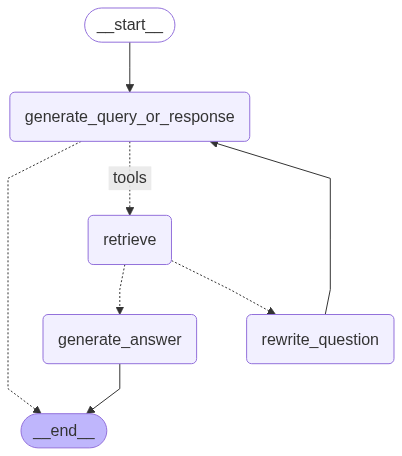

In [27]:
import IPython.display

# 显示图片
IPython.display.Image(graph.get_graph().draw_mermaid_png())

In [ ]:
messages = [HumanMessage("什么是强化学习中的奖励黑客攻击？")]

result = graph.invoke({"messages": messages})

print(result)